In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


mass: mass (in solar masses M⊙)
logg: base-10 logarithm of the surface gravity in CGS units 

In [3]:
def read_data(filename, select_columns):
  'This function reads the data'
  data = pd.read_csv(filename, sep = ',')
  return data[select_columns].to_numpy()

  
def unit_conversion(logg, mass, average_earth_radii, gravitation_constant, solar_mass_kg):
  '''
  This function converts the unit of surface gravity from CGS units to average Earth radii unit.
   WD: mass (in solar masses M⊙),  
   surface gravity: base-10 logarithm  (CGS units). 
  '''

  surface_gravity = 10**logg * 10**-2 # Converting surface gravity from CGS to SI
      
  mass_kg = solar_mass_kg * mass  # Converting solar mass to kg.

  # Radius in m is calculated from Newton's law of universal gravitation.
  # Radius in m used to convert radius of the star to average earth radii unit
  radius_m = np.sqrt(gravitation_constant * mass_kg / surface_gravity)
  radius_avgEarth = (radius_m) / average_earth_radii

  return mass_kg, radius_m, radius_avgEarth # eski: radius_avgEarth, mass_kg, radius_m


In [4]:
average_earth_radii = 6371 * 10**3 # m
gravitation_constant = 6.6743 * 10**-11 # m3 kg-1 s-2
solar_mass_kg = 1.98847 * 10**30 # kg
speed_of_light = 299792458.0 #m s^-1

# 1.b. Show all the points in an M vs R plot using solar masses and average Earth radii as units.


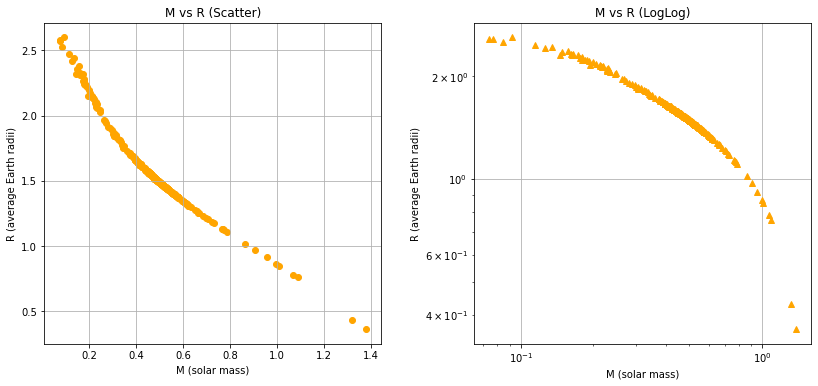

In [5]:
data = read_data('/content/drive/MyDrive/white_dwarf_data.csv', ['logg', 'mass']) # observational data from many low-temperature WDs

logg = data[:, 0]
mass = data[:, 1]

mass_kg, radius_m, radius_avgEarth= unit_conversion(logg,mass, average_earth_radii, gravitation_constant, solar_mass_kg)
fig, ax = plt.subplots(1, 2, figsize=(12,6))  


ax[0].scatter(mass, [unit_conversion(i,j,  average_earth_radii, gravitation_constant, solar_mass_kg)[2] for i,j in zip(logg, mass)], color = 'orange')
ax[0].title.set_text('M vs R (Scatter)')
ax[0].set_xlabel('M (solar mass)')
ax[0].set_ylabel('R (average Earth radii)')
ax[0].grid()


ax[1].loglog(mass, [unit_conversion(i,j,  average_earth_radii, gravitation_constant, solar_mass_kg)[2] for i,j in zip(logg, mass)], color = 'orange', linestyle='None', marker = '^')
ax[1].title.set_text('M vs R (LogLog)')
ax[1].set_xlabel('M (solar mass)')
ax[1].set_ylabel('R (average Earth radii)')
ax[1].grid()

plt.tight_layout(pad =3)
plt.show()

## 1.c. 

In this section we will
  1. Fit the data to find K* and n\*
  2. Using n* and Lane-Emnde equation, find ρc
  3. Plot M vs ρc


In the Lane-Emden equation ξ is a dimensionless radius and θ is related to the density, and thus the pressure, by ρ = ρ$_{c}$θⁿ for central density ρ$_{c}$.
The index *n* is the polytropic index of the polytropic equation of state,
P = K ρ$^{1+1/n}$, where P and ρ are the pressure and density respectively, and K is a constant of proportionality.

Thus, here we will start by giving q and c (proportionality constant of Eq. 7) initial values to iterate further. We will use c to find K.

We are using Eq.7 which gives the relationship between M and R

In [6]:
def terminate_lane_emden(xi, theta, n):
  '''
  This function defines the stopping condition for Lane Emden iteration.
  ''' 
  return theta[0]

def lane_emden_ivp(n):   
  '''
  This functions solves Lane Emden equation. In return, we will obtain x, theta,
  and theta_x_.
  '''
  terminate_lane_emden.terminal = True
  terminate_lane_emden.direction = 0

  ivp_result = solve_ivp(fun=lane_emden_equation, t_span=[0, 100],y0= [1, 0], events=terminate_lane_emden, args=(n,))

  return ivp_result.t, ivp_result.y

def lane_emden_equation(x, theta, n):
  '''
  This function writes the lane emden equation to be used in the solver.
  '''
  if x != 0:
    function = np.array([theta[1], (-x * np.power(theta[0], n, out=np.zeros_like(theta[0]), where=theta[0] > 0) - 2 * theta[1]) / (x)])
    return function
  else:
    function = [theta[1], 0]
    return function

def fitting_function(r, c, q): 
  mass  = c * (r ** ((3 - (q/(5-q))) / (1 - (q/(5-q))))) # mass and radius relation.
  return mass


def fitting_function_sec(r, constant_new): 
  mass  = constant_new * (r ** ((3 - (q_fixed/(5-q_fixed))) / (1 - (q_fixed/(5-q_fixed))))) # mass and radius relation.
  return mass



Curve fitting. Eq 9 from the assessment is only relevant when star is low mass.
We can use Equation 7 from the assessment sheet to fit Equation 8 due to the fact that for low mass WDs x ≪ 1.

In [7]:
average_earth_radii = 6371 * 10**3 # m
gravitation_constant = 6.6743 * 10**-11 # m3 kg-1 s-2
solar_mass_kg = 1.98847 * 10**30 # kg
pi = np.pi
mass_kg, radius_m,radius_avgEarth = unit_conversion(logg,mass, average_earth_radii, gravitation_constant, solar_mass_kg)

q_initial = 3.0 # suggested
prop_const_initial = 3.2e12 # In the article named 'On the theory of white dwarf stars. I. The energy sources of white dwarfs' by Mestel L, C is mentioned to be at 10^12 orders of magnitude. So, using this value.
n = q_initial / (5-q_initial) # one of our conditions


low_mass_threshold = 0.20 # wikipedia says low-mass helium white dwarfs has mass < 0.20 M☉, so I'll take 0.2 as my threshold.

# Selecting low mass mass and radius observations.
mass_select = mass_kg[mass < low_mass_threshold]
r_select = radius_m[mass < low_mass_threshold]


soln1, soln2 = curve_fit(f=fitting_function, xdata=r_select, ydata=mass_select, p0=[prop_const_initial, q_initial])
prop_const, q = soln1


# Now that we obtained c and q, we can use c to obtain K. c is a placeholder for the constant part of mass-radius relation. Equation 7.

x, theta = lane_emden_ivp(n)
x_= x[-1]
theta_x_ = theta[1, -1]

conversion_from_c = (((n + 1) / (4 * pi * gravitation_constant)) ** (((n - 3) / (2 - 2 * n)) + 1.5)) * ((x_) ** (((n - 3) / (1 - n)) + 2)) * 4 * np.pi * (-theta_x_)
K = (prop_const/ conversion_from_c) ** ((n - 1) / (n))

print('Estimated parameters for the fitted curve are as follows:')
print(f'K = {K}\nq = {q}\nC = {prop_const}')


# Now, we estimated K and q from the initial guesses. We will use them to calculate
# mass and central density.

# Calculate mass with estimated values.
eqn1 = (((K * (n + 1)) / (4 * pi * gravitation_constant)) ** (-0.5 * ((3 - n) / (1 - n))))
eqn2 = (((1 / (4 * pi)) * (((4 * pi * gravitation_constant) / (K * (n + 1))) ** 1.5)* (1 / ((x_ ** 2) * (-theta_x_)))) ** (-1))
eqn3 = (x_ ** ((n - 3) / (1 - n))) * (radius_m ** ((3 - n) / (1 - n)))
 
mass_from_kq_estimation = eqn1*eqn2*eqn3

# Calculate central density with estimated values.
rho_from_kq_estimation = ((mass_from_kq_estimation / (4 * pi)) * (((4 * pi * gravitation_constant) / (K * (n + 1))) ** 1.5) * (1 / ((x_ ** 2) * (-theta_x_)))) ** ((2 * n) / (3 - n))

Estimated parameters for the fitted curve are as follows:
K = 4.1701771736549137e-07
q = 3.0
C = 3200000000000.0


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


We know that q is an integer (from theory). Since we cannot constrain a fitting parameter to be an integer, we will set q to be the nearest integer. Then, we will do a second fit for the other parameter, K∗. We had q to be around 3 as per the suggestion.


In [8]:
# We are using initial guesses from the previous part.

q_fixed = np.round(q) # make integer
constant_new = prop_const
n = q_fixed / (5-q_fixed) # one of our conditions


# Following a similar logic, we fit another curve. Now q is fixed, so we will obtain c only

soln1_new, soln2_new = curve_fit(f=fitting_function_sec, xdata=r_select, ydata=mass_select, p0=[constant_new])
prop_const_new = soln1_new


x, theta = lane_emden_ivp(n)
x_ = x[-1]
theta_x_ = theta[1, -1]

K_new = (prop_const_new / conversion_from_c) ** ((n - 1) / (n))

print('Estimated parameters for the fitted curve are as follows:')
print(f'K = {K_new}\nq = {q_fixed}\nC = {prop_const_new}')


# Calculate mass with estimated values.
eqn1 = (((K_new * (n + 1)) / (4 * pi * gravitation_constant)) ** (-0.5 * ((3 - n) / (1 - n))))
eqn2 = (((1 / (4 * np.pi)) * (((4 * pi * gravitation_constant) / (K_new * (n + 1))) ** 1.5)* (1 / ((x_ ** 2) * (-theta_x_)))) ** (-1))
eqn3 = (x_ ** ((n - 3) / (1 - n))) * (radius_m ** ((3 - n) / (1 - n)))

mass_from_k_estimation = eqn1 * eqn2 * eqn3
# Calculate central density with estimated values.
rho_from_k_estimation = ((mass_from_k_estimation / (4 * pi)) * (((4 * pi * gravitation_constant) / (K_new * (n + 1))) ** 1.5) * (1 / ((x_ ** 2) * (-theta_x_)))) ** ((2 * n) / (3 - n))


Estimated parameters for the fitted curve are as follows:
K = [4.17017717e-07]
q = 3.0
C = [3.2e+12]


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


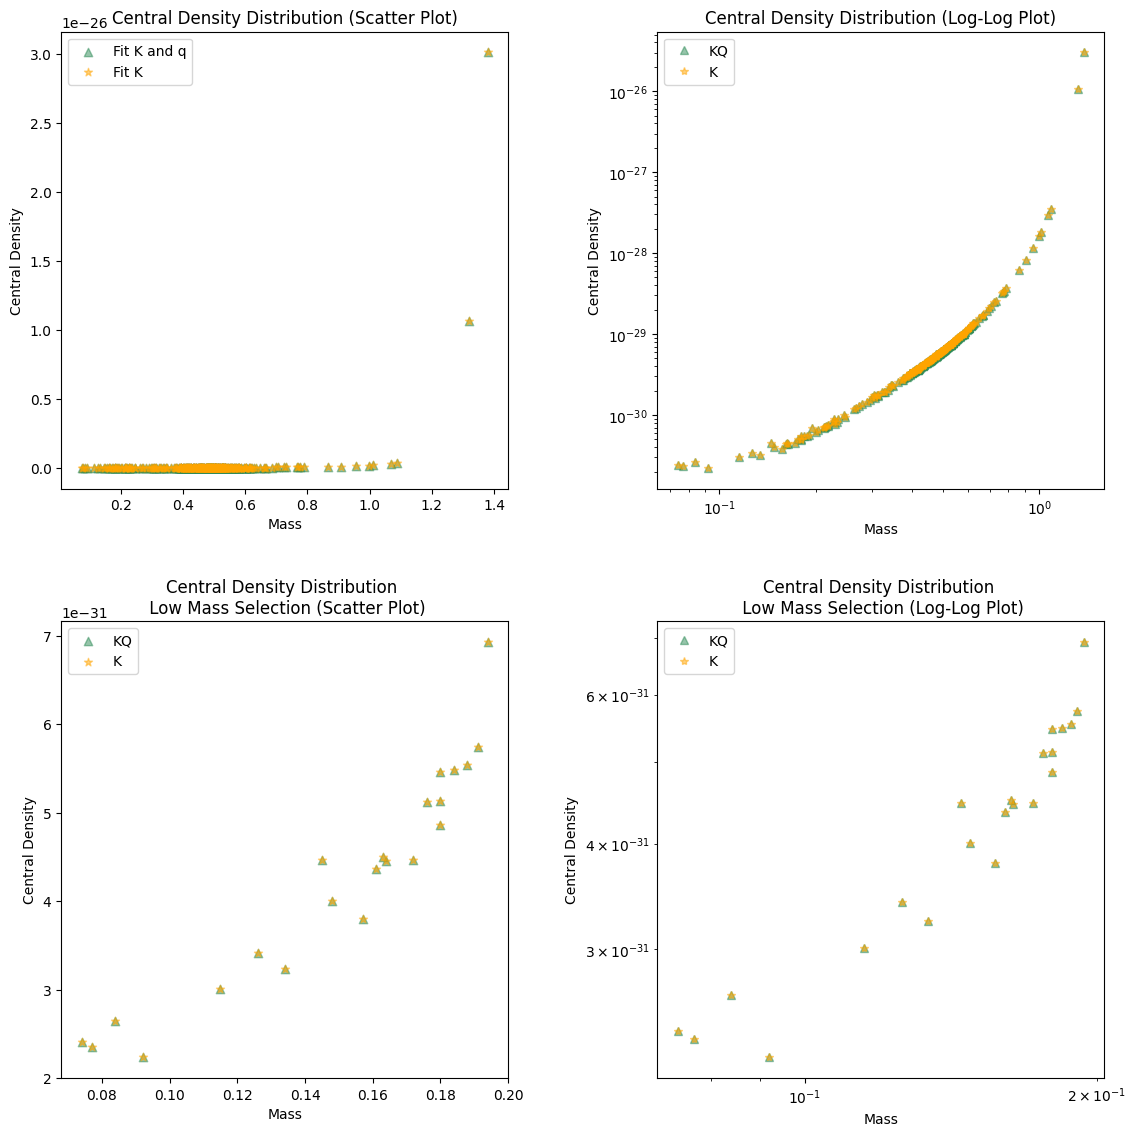

In [9]:
# Central Density Distribution 
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12,12), dpi = 100)
axs[0][0].scatter(mass, rho_from_kq_estimation, c = 'seagreen', label = 'Fit K and q', alpha = 0.5,marker = '^')
axs[0][0].scatter(mass, rho_from_k_estimation, c = 'orange', label = 'Fit K', alpha = 0.5, marker = '*')
axs[0][0].legend(fontsize =10, loc = 'upper left')
axs[0][0].set_xlabel('Mass')
axs[0][0].set_ylabel('Central Density')

axs[0][0].title.set_text('Central Density Distribution (Scatter Plot)')

axs[0][1].loglog(mass,rho_from_kq_estimation, linestyle='None', c = 'seagreen', label = 'KQ',  alpha = 0.5, marker = '^')
axs[0][1].loglog(mass,rho_from_k_estimation, linestyle='None', c = 'orange', label = 'K',  alpha = 0.5, marker = '*')
axs[0][1].legend(fontsize =10, loc = 'upper left')
axs[0][1].title.set_text('Central Density Distribution (Log-Log Plot)')
axs[0][1].set_xlabel('Mass')
axs[0][1].set_ylabel('Central Density')

axs[1][0].scatter(mass[mass < low_mass_threshold], rho_from_kq_estimation[mass < low_mass_threshold], c = 'seagreen', label = 'KQ', alpha = 0.5,marker = '^')
axs[1][0].scatter(mass[mass < low_mass_threshold], rho_from_k_estimation[mass < low_mass_threshold], c = 'orange', label = 'K', alpha = 0.5,marker = '*')
axs[1][0].legend(fontsize =10, loc = 'upper left')
axs[1][0].title.set_text('Central Density Distribution {} Low Mass Selection (Scatter Plot)'.format('\n'))
axs[1][0].set_xlabel('Mass')
axs[1][0].set_ylabel('Central Density')

axs[1][1].loglog(mass[mass < low_mass_threshold],rho_from_kq_estimation[mass < low_mass_threshold], linestyle='None', c = 'seagreen', label = 'KQ',  alpha = 0.5,marker = '^')
axs[1][1].loglog(mass[mass < low_mass_threshold],rho_from_k_estimation[mass < low_mass_threshold], linestyle='None', c = 'orange', label = 'K',  alpha = 0.5,marker = '*')
axs[1][1].legend(fontsize =10, loc = 'upper left')
axs[1][1].title.set_text('Central Density Distribution {} Low Mass Selection (Log-Log Plot)'.format('\n'))
axs[1][1].set_xlabel('Mass')
axs[1][1].set_ylabel('Central Density')
fig.tight_layout(pad = 3)
#plt.savefig('/content/cdensityVSdensity.png')
plt.show()

## 1.d. PASS

1.e.  Calculating theoretical values

In [10]:
# Using equation 11 to calculate theoretical value

q = 3
mu = 1.6605390666e-27 #kg atomic mass constant
me = 9.1093837015e-31 # e mass 
hbar = (6.62607015e-34)/(2*np.pi) #J Hz^-1
c = 299792458.0 #m s^-1
pi = np.pi

D = (mu * (me ** 3) * (c ** 3) * 2) / (3 * (pi ** 2) * (hbar ** 3))
C = ((me**4) * (c**5)) / (24 * (pi ** 2) * (hbar ** 3))
K = (8 * C) / (5 * (D ** (5 / q))) # Equation 10

print('Theoretical values are:')
print(f'q: {q}, D: {D}, C: {C}, K: {K}')

Theoretical values are:
q: 3, D: 1947864333.345182, C: 6.002332185660436e+21, K: 3161128.6219916763


# Q2

In [11]:
def terminate_tov(r, initials, K, n): 
  '''
  This function defines the stopping condition for TOV iteration.
  '''
  m, v, p, mp = initials
  return p - 1e-50

def tov_equation(r, initials, K, n):
  '''
  This function writes TOV equation to be solved in the solver.
  Equation 12 from the assignment sheet, relating density and pressure.
  Writing equations 13, 14,15 and 16 from the assignment sheet)
  '''
  m, v, p, mp = initials
  rho = (np.abs(p) / K) ** (1/2) # n = 1 for neutron stars
  m_update = 4 * np.pi * (r ** 2) * rho # eqn 13
  v_nominator = (m + 4 * np.pi * (r ** 3) * p) 
  v_denominator = (r * (r - 2 * m))  
  if v_denominator != 0: # eqn 14
      v_update = 2 * (v_nominator / v_denominator)
  else: # NoneType Error 
      v_update = 0  
  p_update = -0.5 * (p + rho) * v_update   # eqn 15
  if r != 0: # baryonic mass # eqn 16
      m_p_update = 4 * np.pi * ((1 - ((2 * m) / (r))) ** (-0.5)) * (r ** 2) * rho 
  else:
      m_p_update = 0

  return m_update, v_update, p_update, m_p_update



def tov_ivp(pc, K, n):
  '''
  This function solves TOV equation.
  '''
  initials = [0, 0, pc, 0] # Initial value for mass, time dilation, pressure, baryonic mass
  terminate_tov.terminal = True 
  terminate_tov.direction = 0 # trigger event. 
  r = solve_ivp(fun=tov_equation, t_span=[0, 1e3], #NS radius 
                y0=initials, events=terminate_tov, args=(K, n), max_step = 1)
  points = r.t 
  solution = r.y
  return points, solution
 


In [12]:
n = 1
# Values for constant K, leaving 100 in the middle
kns_points = np.arange(50,150)
# Values for central pressure, convert to geometric units.
cp_count =  len(kns_points) * 5
cp = np.logspace(0, 46, cp_count) * (((gravitation_constant ** 3) * (solar_mass_kg ** 2)) / (speed_of_light ** 8)) # Tried different values but gives error above 46

# TOV equation variables
mass = np.zeros((len(kns_points),cp_count))
radius = np.zeros((len(kns_points), cp_count))
bary_mass = np.zeros((len(kns_points), cp_count))

# Iteration 
for i in range(len(kns_points)):
  for j in range(len(cp)):
    points, solution = tov_ivp(cp[j], kns_points[i], n)
    # Get the latest element of mass, radius and rest mass solutions
    mass[i, j] = solution[0, -1]
    bary_mass[i, j] = solution[-1, -1]
    radius[i, j] = points[-1]
    
ind = np.where(kns_points == 100)[0][0]
# Pressure to density conversion, from equation 9.
rho = (np.abs(cp) / kns_points[ind]) ** (1/2) # n = 1 for neutron stars
# Geometric unit to SI unit as we will plot with SI
rho_si = rho / (((gravitation_constant ** 3) * (solar_mass_kg ** 2)) / (speed_of_light ** 6))
radius_si = radius * ((gravitation_constant * solar_mass_kg) / (speed_of_light ** 2)) / 1000

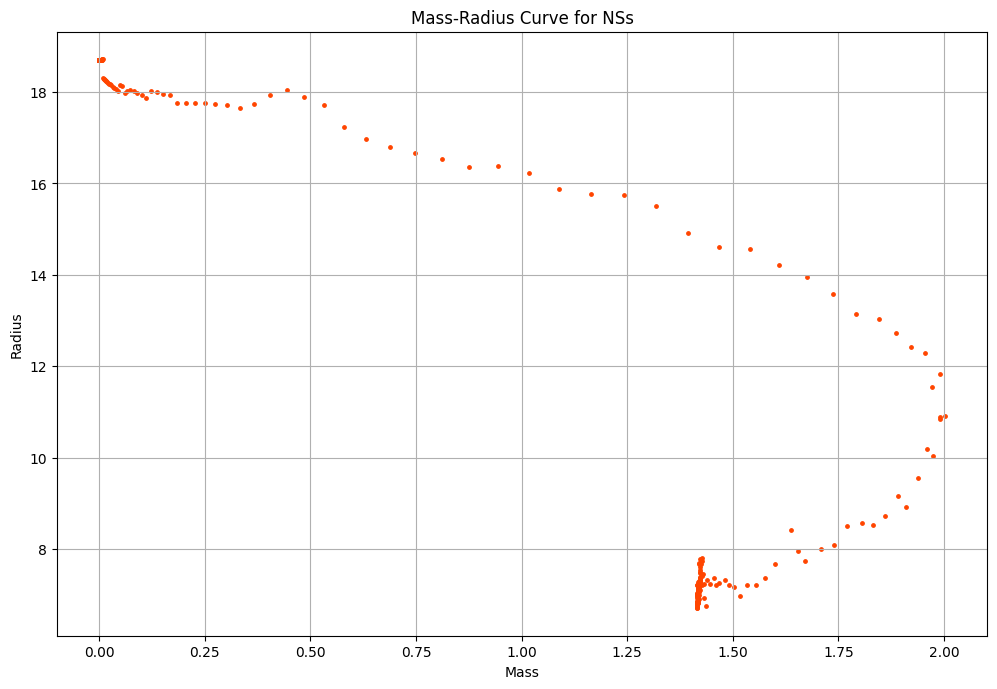

In [13]:
# In the units that are designed such that the values of physical quantities in 
# this problem will be around unity.

mass_indices = mass[ind, :]
radius_indices = radius_si[ind, :]
plt.figure(dpi = 100, figsize = (12,8))
plt.scatter(mass_indices,radius_indices , s= 6, c = 'orangered')
plt.xlabel('Mass')
plt.ylabel('Radius')
plt.grid()
plt.title('Mass-Radius Curve for NSs')
plt.show()

b. Plot ∆ vs R. 
As suggested fractional binding energy is obtained in above integration using formula 16 and 17.

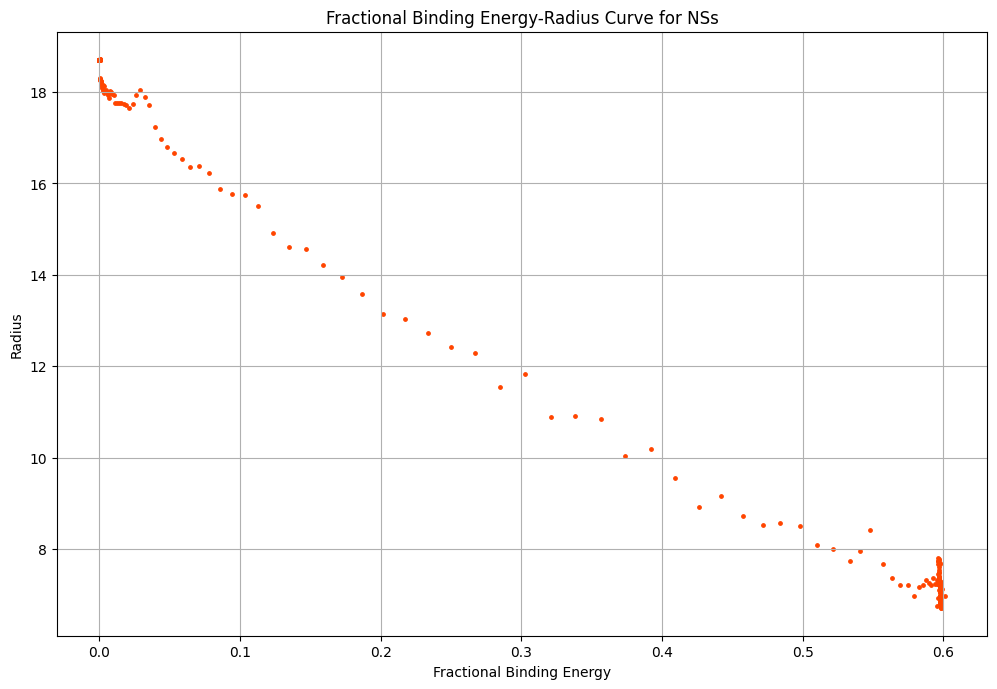

In [14]:
frac_bind_energy = (bary_mass - mass) / mass 
frac_indices = frac_bind_energy[ind, :]
radius_indices = radius_si[ind, :]
plt.figure(dpi = 100, figsize = (12,8))
plt.scatter(frac_indices, radius_indices , s= 6, c = 'orangered' )
plt.xlabel('Fractional Binding Energy')
plt.ylabel('Radius')
plt.grid()
plt.title('Fractional Binding Energy-Radius Curve for NSs')
plt.show()

c. Plot the M vs ρc curve. Stability criteria are given in equation18 and 19. We need to take derivative of M wrt pc.

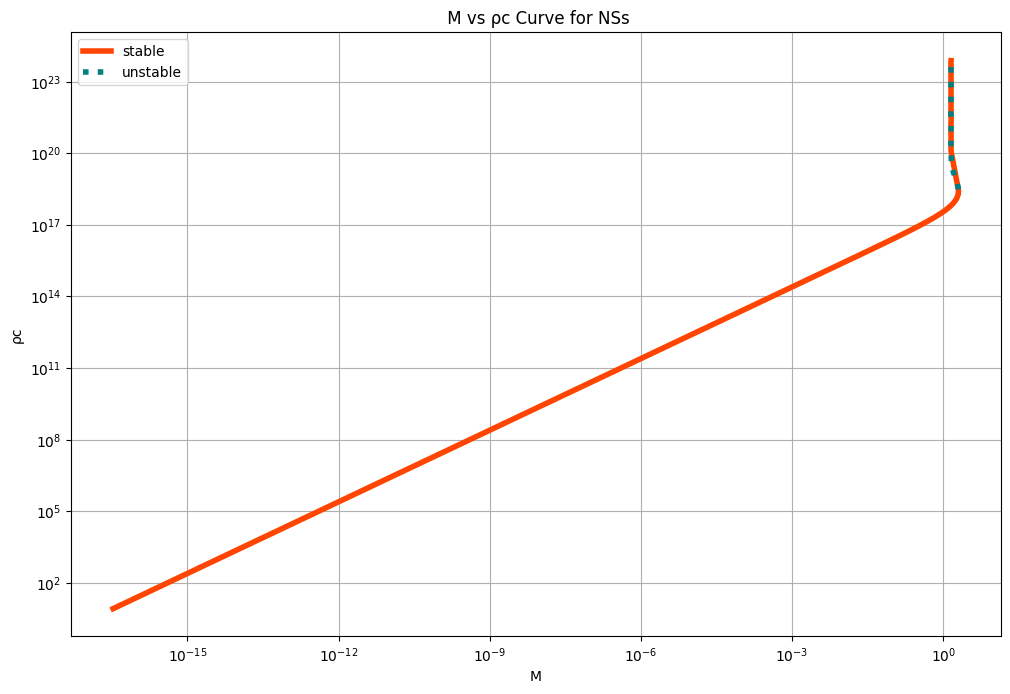

In [15]:
derivative = np.gradient(mass_indices, rho_si)
stable_dict = []
instable_dict = []

for i in range(len(derivative)):
  if derivative[i] < 0:
    instable_dict.append(i)
  else:
    stable_dict.append(i)

stable_mass = mass[ind, stable_dict]
instable_mass = mass[ind, instable_dict]

stable_rho = rho_si[stable_dict]
instable_rho = rho_si[instable_dict]

plt.figure(dpi = 100, figsize = (12,8))
plt.loglog(stable_mass, stable_rho, c = 'orangered',  linewidth=4.0, label = 'stable')
plt.loglog( instable_mass, instable_rho, c= 'teal', linestyle = 'dotted', linewidth=4.0, label = 'unstable')
plt.legend()
plt.xlabel('M')
plt.ylabel('ρc')
plt.grid()
plt.title(' M vs ρc Curve for NSs')
plt.legend()
plt.show()

d. Plot Mmax(K) vs K

No handles with labels found to put in legend.
No handles with labels found to put in legend.


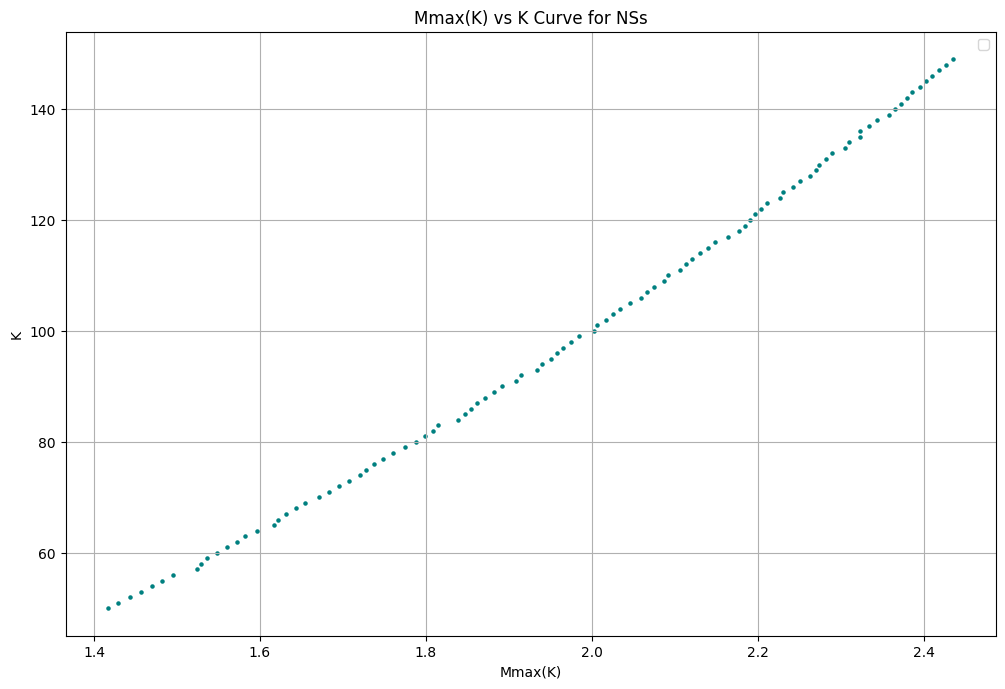

In [16]:
# Get of the maximum masses for each constant from the mass container.
mass_max = np.max(mass, axis = 1)
plt.figure(dpi = 100, figsize = (12,8))
plt.scatter(mass_max, kns_points, c = 'teal', s = 5)
plt.legend()
plt.xlabel('Mmax(K)')
plt.ylabel('K')
plt.title('Mmax(K) vs K Curve for NSs')
plt.grid()
plt.legend()
plt.show()

The most massive neutron star to be observed so far has a mass of 2.14M⊙, we'll use this value to constraint maximum mass

In [17]:
max_allowable = np.where(abs(mass_max -  2.14) < 1e-3)
max_allowable_kns_y = mass_max[max_allowable][0]
max_allowable_kns_x_lower = kns_points[0]
max_allowable_kns_x_upper = kns_points[-1]


In [18]:
max_allowable_m_x = [kns_points[max_allowable][0]]
max_allowable_m_y_lower = mass_max[0]
max_allowable_m_y_upper =  mass_max[-1]

No handles with labels found to put in legend.
No handles with labels found to put in legend.


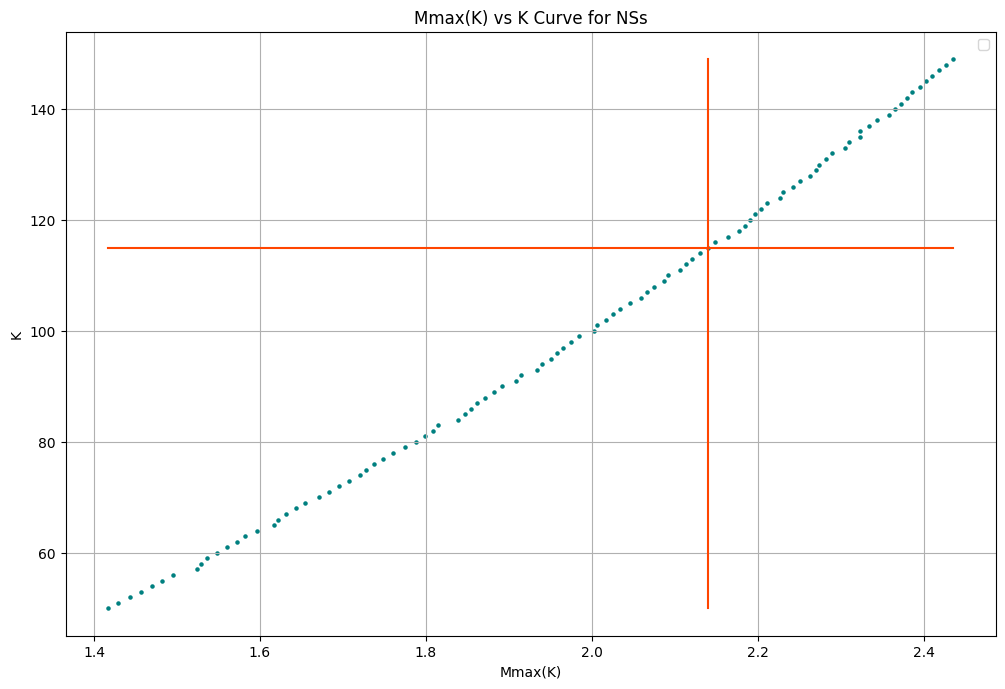

In [19]:
plt.figure(dpi = 100, figsize = (12,8))

plt.plot(np.array([mass_max[max_allowable][0], mass_max[max_allowable][0]]),np.array([max_allowable_kns_x_lower, max_allowable_kns_x_upper ]), color = "orangered")
plt.plot(np.array(np.array([max_allowable_m_y_lower, max_allowable_m_y_upper])), [kns_points[max_allowable][0], kns_points[max_allowable][0]], color = "orangered")
plt.legend()
plt.scatter(mass_max, kns_points, c = 'teal', s = 5)

plt.xlabel('Mmax(K)')
plt.ylabel('K')
plt.title('Mmax(K) vs K Curve for NSs')
plt.grid()
plt.legend()
plt.show()